# Quantium task 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [86]:
import io
import requests
url="https://cdn.theforage.com/vinternships/companyassets/32A6DqtsbF7LbKdcq/QVI_data.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

### Cleaning and preparing data for analysis

In [87]:
df['DATE']=pd.to_datetime(df["DATE"], format="%Y/%m/%d")
df['PROD_NAME']=df['PROD_NAME'].astype('string')

In [89]:
df['LIFESTAGE']=df['LIFESTAGE'].astype('string')
df['BRAND']=df['BRAND'].astype('string')
df['PREMIUM_CUSTOMER']=df['PREMIUM_CUSTOMER'].astype('string')

In [98]:
df = df[ df[ 'PROD_NAME' ].str.contains( "Old El Paso" )==False]
df['PROD_NAME'] = df['PROD_NAME'].str.replace('&','')
df['PROD_NAME'] = df['PROD_NAME'].str.replace('/','')

In [91]:
df.loc[df['PROD_NBR'] == 4, 'PROD_NAME'] = "Doritos Corn Chp Supreme 380g"
df.loc[df['PROD_NBR'] == 105, 'PROD_NAME'] = "WW Cheese Rings 190g"
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Red Rock Deli','RRD')
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Infzns','RRDnfuzions')
df.loc[df['PROD_NBR'] == 82, 'PROD_NAME'] = "Smiths Crinkle Cut Mac N Cheese 150g"
df.loc[df['PROD_NBR'] == 43, 'PROD_NAME'] = "Smiths Crinkle Cut Bolognese 150g"
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Snbts','Sunbites')
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Grain Waves','Grain_Waves')
df['PROD_NAME'] = df['PROD_NAME'].str.replace('GrnWves','Grain_Waves')
df.loc[df['PROD_NBR'] == 5, 'PROD_NAME'] = "NCC SeaSalt 175g"
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Natural Chip Compny','NCC')
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Natural ChipCo','NCC')
df['PROD_NAME'] = df['PROD_NAME'].str.replace('Natural Chip Co','NCC')

In [92]:
df['DATE_MY']=df['DATE']
df['DATE_MY'] = pd.to_datetime(df['DATE_MY'],format='%Y-%m').dt.to_period('M')

### Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

#### Defining a function for metrics

In [148]:
def month_store_metrics():
    store_ym_group = df.groupby(['STORE_NBR', 'DATE_MY'])
    total = store_ym_group['TOT_SALES'].sum()
    num_cust = store_ym_group['LYLTY_CARD_NBR'].nunique()
    trans_per_cust = (store_ym_group.size()/ num_cust).round(decimals=2)
    avg_chips_per_cust = (store_ym_group['PROD_QTY'].sum() / num_cust).round(decimals=2)
    avg_chips_price = (total / store_ym_group['PROD_QTY'].sum()).round(decimals=2)
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ['TOT_SALES', 'num_Customers', 'num_TransactionsPerCust', 'num_ChipsPerCust','avgPricePerUnit']
    return metrics

In [149]:
df_month_metrics = month_store_metrics().reset_index()
df_month_metrics.head(1)

,STORE_NBR,DATE_MY,TOT_SALES,num_Customers,num_TransactionsPerCust,num_ChipsPerCust,avgPricePerUnit
0,1,2018-07,191.6,48,1.04,1.23,3.25


#### Filter to the pre-trial period and stores with full observation periods

In [157]:
observations_counts = df_month_metrics['STORE_NBR'].value_counts()
full_observ_index = observations_counts[observations_counts == 12].index
full_observ = df_month_metrics[df_month_metrics['STORE_NBR'].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ['DATE_MY'].astype('string') < "2019-03"]
pretrial_full_observ.head(9)

,STORE_NBR,DATE_MY,TOT_SALES,num_Customers,num_TransactionsPerCust,num_ChipsPerCust,avgPricePerUnit
0,1,2018-07,191.6,48,1.04,1.23,3.25
1,1,2018-08,171.0,42,1.00,1.26,3.23
2,1,2018-09,273.7,58,1.05,1.28,3.70
3,1,2018-10,188.1,44,1.02,1.32,3.24
4,1,2018-11,187.5,45,1.02,1.24,3.35
5,1,2018-12,169.2,40,1.10,1.32,3.19
6,1,2019-01,149.7,35,1.00,1.17,3.65
7,1,2019-02,199.9,50,1.04,1.20,3.33
12,2,2018-07,145.7,38,1.05,1.18,3.24


#### Correlation of the performance of each store to the  trial one

In [164]:
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_numbs = inputTable[~inputTable['STORE_NBR'].isin([77, 86, 88])]['STORE_NBR'].unique()
    corrs = pd.DataFrame(columns = ['DATE_MY', 'Trial_Str', 'Ctrl_Str', 'Corr_Score'])
    trial_store = inputTable[inputTable['STORE_NBR'] == storeComparison][metricCol].reset_index()
    for control in control_store_numbs:
        concat_df = pd.DataFrame(columns = ['DATE_MY', 'Trial_Str', 'Ctrl_Str', 'Corr_Score'])
        control_store = inputTable[inputTable['STORE_NBR'] == control][metricCol].reset_index()
        concat_df['Corr_Score'] = trial_store.corrwith(control_store, axis=1)
        concat_df['Trial_Str'] = storeComparison
        concat_df['Ctrl_Str'] = control
        concat_df['DATE_MY'] = list(inputTable[inputTable['STORE_NBR'] == storeComparison]['DATE_MY'])
        corrs = pd.concat([corrs, concat_df])
    return corrs

In [170]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(['TOT_SALES', 'num_Customers', 'num_TransactionsPerCust', 'num_ChipsPerCust', 'avgPricePerUnit'], trial_num)])
corr_table.head(8)

,DATE_MY,Trial_Str,Ctrl_Str,Corr_Score
0,2018-07,77,1,0.043859
1,2018-08,77,1,0.025753
2,2018-09,77,1,0.002356
3,2018-10,77,1,-0.031669
4,2018-11,77,1,0.006964
5,2018-12,77,1,0.063099
6,2019-01,77,1,0.000910
7,2019-02,77,1,0.018447


#### Magnitude distance

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

In [171]:
def MagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_numbs = inputTable[~inputTable['STORE_NBR'].isin([77, 86, 88])]['STORE_NBR'].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable['STORE_NBR'] == storeComparison][metricCol]
    for control in control_store_numbs:
        concat_df  = abs(inputTable[inputTable['STORE_NBR'] == storeComparison].reset_index()[metricCol] - inputTable[inputTable['STORE_NBR'] == control].reset_index()[metricCol])
        concat_df['DATE_MY'] = list(inputTable[inputTable['STORE_NBR'] == storeComparison]['DATE_MY'])
        concat_df['Trial_Str'] = storeComparison
        concat_df['Ctrl_Str'] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists['magnitude'] = dists[metricCol].mean(axis=1)
    return dists

In [172]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, MagnitudeDistance(['TOT_SALES', 'num_Customers', 'num_TransactionsPerCust', 'num_ChipsPerCust', 'avgPricePerUnit'], trial_num)])
dist_table.head(8)

,TOT_SALES,num_Customers,num_TransactionsPerCust,num_ChipsPerCust,avgPricePerUnit,DATE_MY,Trial_Str,Ctrl_Str,magnitude
0,0.935084,0.99,0.909091,0.726027,0.874251,2018-07,77,1,0.886891
1,0.935313,0.95,0.954545,0.787671,0.868263,2018-08,77,1,0.899159
2,0.962872,0.84,1.000000,0.732877,0.712575,2018-09,77,1,0.849665
3,0.995254,0.92,0.977273,0.952055,0.610778,2018-10,77,1,0.891072
4,0.971370,0.94,0.863636,0.739726,0.868263,2018-11,77,1,0.876599
5,0.924902,0.94,0.931818,0.828767,0.688623,2018-12,77,1,0.862822
6,0.958126,1.00,0.750000,0.527397,0.694611,2019-01,77,1,0.786027
7,0.980939,0.94,0.909091,0.698630,0.874251,2019-02,77,1,0.880582


#### Looking for control stores

Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [173]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = MagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=['DATE_MY', 'Trial_Str', 'Ctrl_Str'])
    return combine

- Comparing metrics by sales

In [175]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(['TOT_SALES'], trial_num)])

In [176]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

Determining the top five highest composite score for each trial based on Total sales"

In [177]:
grouped_comparison_table1 = compare_metrics_table1.groupby(['Trial_Str', 'Ctrl_Str']).mean().reset_index()
grouped_comparison_table1['CompScore'] = (corr_weight * grouped_comparison_table1['Corr_Score']) + (dist_weight * grouped_comparison_table1['magnitude'])
for trial_num in compare_metrics_table1['Trial_Str'].unique():
    print(grouped_comparison_table1[grouped_comparison_table1['Trial_Str'] == trial_num].sort_values(ascending=False, by='CompScore').head(),'')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.986393   0.993196
177         77       188         1.0   0.980805   0.990402
239         77       255         1.0   0.977551   0.988776
200         77       214         1.0   0.975465   0.987733
120         77       131         1.0   0.974881   0.987441 
     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
401         86       155         1.0   0.964298   0.982149
356         86       109         1.0   0.956165   0.978082
489         86       247         1.0   0.950747   0.975374
418         86       172         1.0   0.945870   0.972935
406         86       160         1.0   0.943222   0.971611 
     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
551         88        40         1.0   0.933481   0.966741
538         88        26         1.0   0.890824   0.945412
568         88        58         1.0   0.881995   0.940998
582         88        72         1.0   0.880046   0.94

/var/folders/lc/rz1s07_x489gqfyjj0mjdjjc0000gn/T/ipykernel_32715/3632290488.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_comparison_table1 = compare_metrics_table1.groupby(['Trial_Str', 'Ctrl_Str']).mean().reset_index()


- Comparing metrics by customers

In [178]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(['num_Customers'], trial_num)])

In [179]:
grouped_comparison_table2 = compare_metrics_table2.groupby(['Trial_Str', 'Ctrl_Str']).mean().reset_index()
grouped_comparison_table2['CompScore'] = (corr_weight * grouped_comparison_table2['Corr_Score']) + (dist_weight * grouped_comparison_table2['magnitude'])
for trial_num in compare_metrics_table2['Trial_Str'].unique():
    print(grouped_comparison_table2[grouped_comparison_table2['Trial_Str'] == trial_num].sort_values(ascending=False, by='CompScore').head())

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0    0.98625   0.993125
38          77        41         1.0    0.97250   0.986250
15          77        17         1.0    0.97125   0.985625
105         77       115         1.0    0.96500   0.982500
138         77       149         1.0    0.96000   0.980000
     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
401         86       155         1.0   0.960280   0.980140
471         86       229         1.0   0.950935   0.975467
315         86        62         1.0   0.949766   0.974883
489         86       247         1.0   0.949766   0.974883
310         86        57         1.0   0.948598   0.974299
     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
736         88       237         1.0   0.978659   0.989329
551         88        40         1.0   0.943089   0.971545
701         88       199         1.0   0.940041   0.970020
668         88       165         1.0   0.928862   0.9644

/var/folders/lc/rz1s07_x489gqfyjj0mjdjjc0000gn/T/ipykernel_32715/4049685230.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_comparison_table2 = compare_metrics_table2.groupby(['Trial_Str', 'Ctrl_Str']).mean().reset_index()


Based on our findings we can say that for our trial stores we found control stores
- Trial 77 - Control 233
- Trial 86 - Control 155
- Trial 88 - Control 40

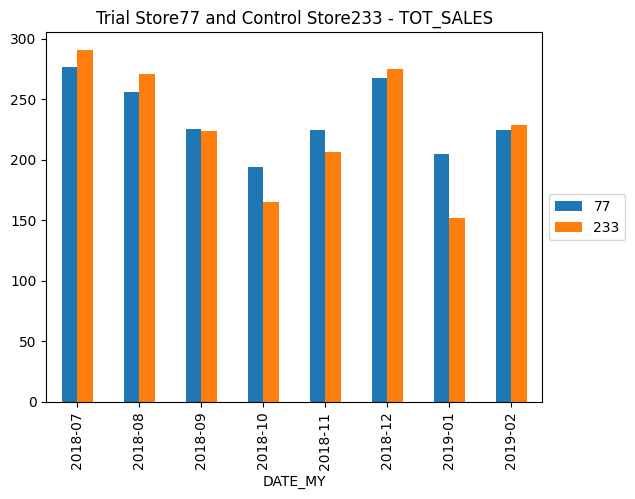

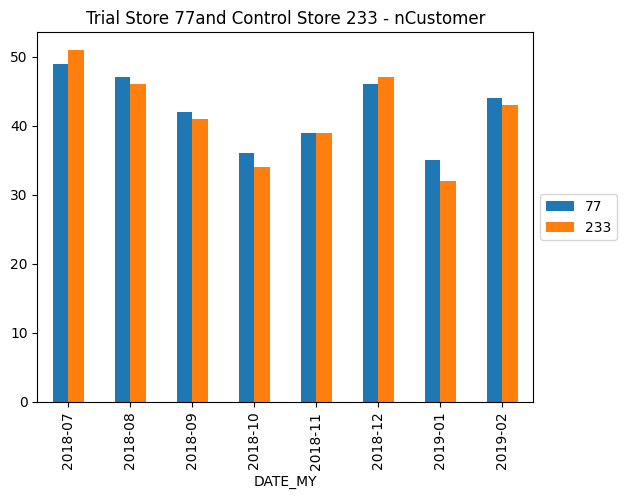

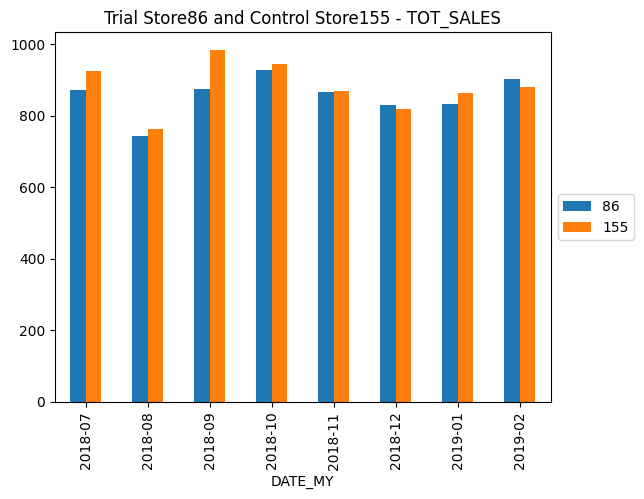

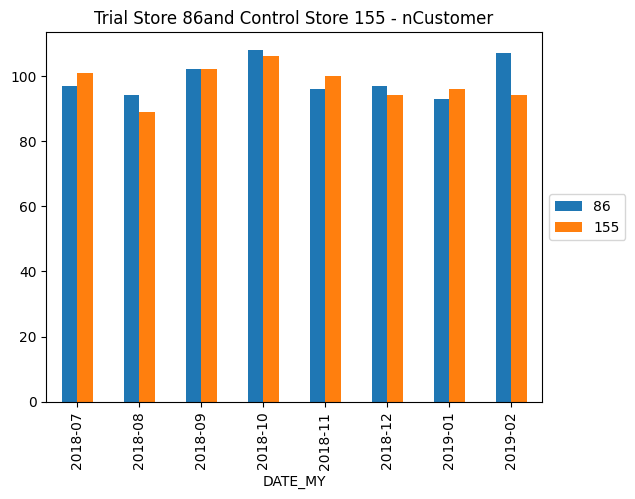

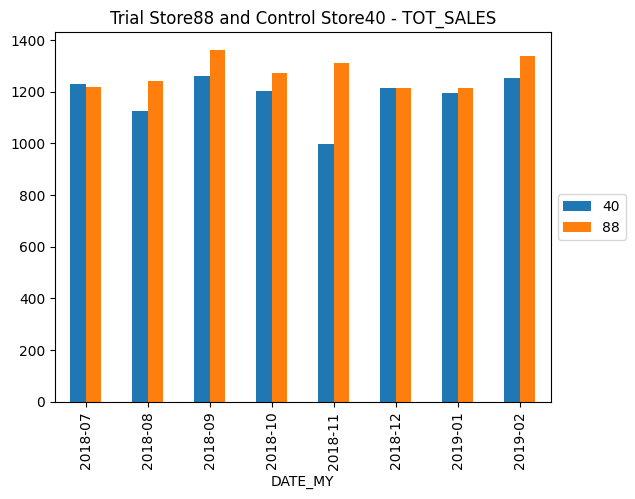

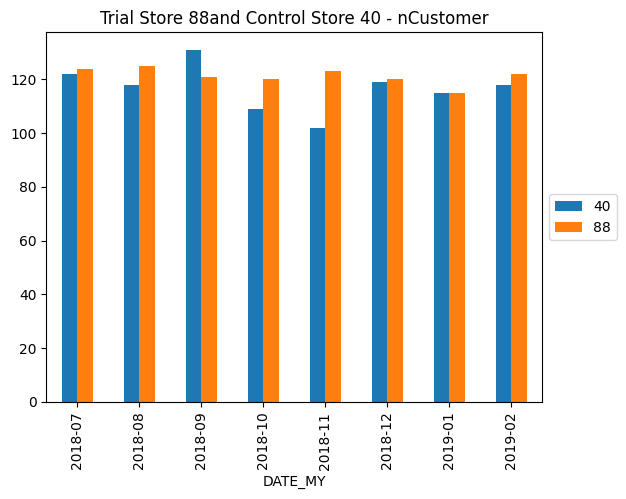

In [256]:
trial_control_dic = {77:233, 86:155, 88:40}
for key, val in trial_control_dic.items():
    pretrial_full_observ[pretrial_full_observ['STORE_NBR'].isin([key, val])].groupby(['DATE_MY', 'STORE_NBR']).sum()['TOT_SALES'].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title('Trial Store' +str(key)+ ' and Control Store' +str(val)+ ' - TOT_SALES')
    plt.show()
    pretrial_full_observ[pretrial_full_observ['STORE_NBR'].isin([key, val])].groupby(['DATE_MY', 'STORE_NBR']).sum()['num_Customers'].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title('Trial Store '+str(key)+'and Control Store '+str(val)+' - nCustomer')
    plt.show()
    print('')

In [257]:
# Ratios for each trial stores
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == 77]['TOT_SALES'].sum() / pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == 233]['TOT_SALES'].sum()

sales_ratio_86 = pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == 86]['TOT_SALES'].sum() / pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == 155]['TOT_SALES'].sum()

sales_ratio_88 = pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == 88]['TOT_SALES'].sum() / pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == 40]['TOT_SALES'].sum()

Next number of customers

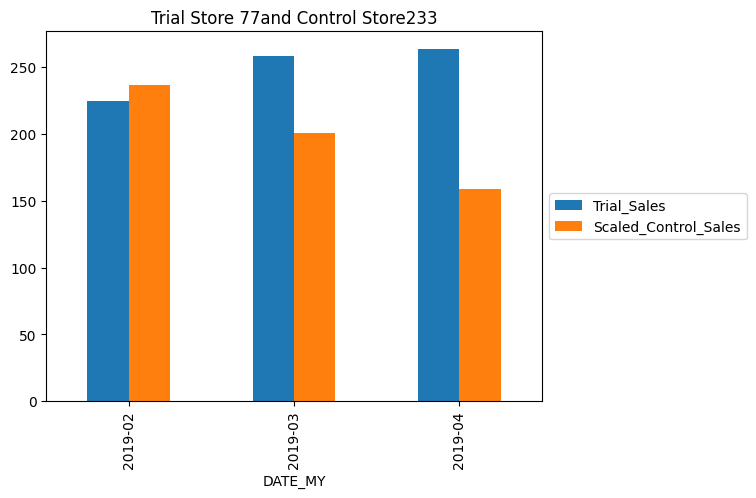

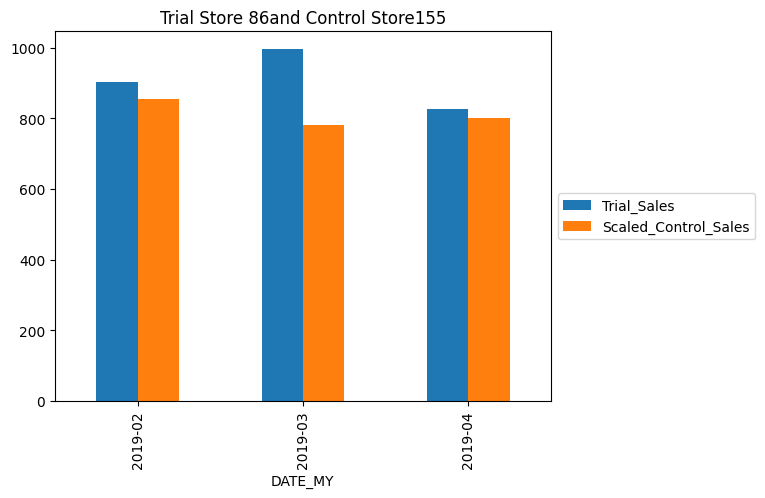

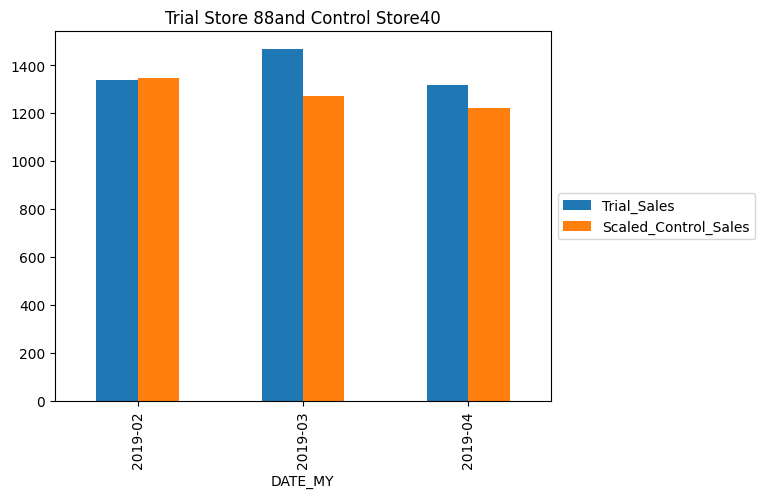

In [258]:
trial_full_observ = full_observ[(full_observ['DATE_MY'].astype('string') >= "2019-02") & (full_observ['DATE_MY'].astype('string') <= "2019-04")]
scaled_sales_control_stores = full_observ[full_observ['STORE_NBR'].isin([233, 155, 40])][['STORE_NBR', 'DATE_MY', 'TOT_SALES']]
def scaler(row):
    if row['STORE_NBR'] == 233:
        return row['TOT_SALES'] * sales_ratio_77
    elif row['STORE_NBR'] == 155:
        return row['TOT_SALES'] * sales_ratio_86
    elif row['STORE_NBR'] == 40:
        return row['TOT_SALES'] * sales_ratio_88
scaled_sales_control_stores['ScaledSales'] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)
trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores['DATE_MY'].astype('string') >= "2019-02") & (scaled_sales_control_stores['DATE_MY'].astype('string') <= "2019-04")]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores['DATE_MY'].astype('string') < "2019-02"]
percentage_diff = {}
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores['STORE_NBR'] == control]
    b = trial_full_observ[trial_full_observ['STORE_NBR'] == trial][['STORE_NBR', 'DATE_MY', 'TOT_SALES']]
    percentage_diff[trial] = b['TOT_SALES'].sum() / a['ScaledSales'].sum()
    b[['DATE_MY', 'TOT_SALES']].merge(a[['DATE_MY', 'ScaledSales']],on='DATE_MY').set_index('DATE_MY').rename(columns={'ScaledSales':'Scaled_Control_Sales', 'TOT_SALES':'Trial_Sales'}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title('Trial Store ' +str(trial)+ 'and Control Store' +str(control))

Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [250]:
percentage_diff

{77: 1.2533292331543362, 86: 1.1179517011681908, 88: 1.137747430662213}

#### Checking significance of Trial minus Control stores by Total SALES Percentage Difference Pre-Trial vs Trial


- 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance
- 2: Proof control and trial stores are similar statistically
    - Check p-value of control store's Pre-Trial vs Trial store's Pre-Trial.
    - If <5%, it is significantly different. If >5%, it is not significantly different (similar).
- 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage

    - Difference between Trial and Control stores during pre-trial is the same as during trial.
    - Check T-Value of Percentage Difference of each Trial month (Feb, March, April 2019).
    - Mean is mean of Percentage Difference during pre-trial.\r\n",
    - Standard deviation is stdev of Percentage Difference during pre-trial.
    - Formula is Trial month's Percentage Difference minus Mean, divided by Standard deviation.
    - Compare each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [259]:
from scipy.stats import ttest_ind, t
for num in [40, 155, 233]:
    print('Store', num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores['STORE_NBR'] == num]['ScaledSales'] , 
                    trial_scaled_sales_control_stores[trial_scaled_sales_control_stores['STORE_NBR'] == num]['ScaledSales'], equal_var=False),'')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores['STORE_NBR'] == num]['ScaledSales']), 
       #   len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores['STORE_NBR'] == num]['ScaledSales']))
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores['STORE_NBR'] == num]),
                                              len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores['STORE_NBR'] == num])])-1))

Store 40
Ttest_indResult(statistic=-0.36013226673707155, pvalue=0.7312292961250687) 
Store 155
Ttest_indResult(statistic=1.2044203899163697, pvalue=0.2662740387858787) 
Store 233
Ttest_indResult(statistic=1.1354171685025711, pvalue=0.30148388979908475) 
Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


We see that p-value is bigger than o,5 for store 40

In [191]:
a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores['STORE_NBR'] == 40]['ScaledSales']
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores['STORE_NBR'] == 40]['ScaledSales']

In [196]:
for trial, cont in trial_control_dic.items():
    print('Trial store:', trial, ', Control store', cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == trial]['TOT_SALES'],
                    pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores['STORE_NBR'] == cont]['ScaledSales'],equal_var=True),' ')
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ['STORE_NBR'] == trial])-1))

Trial store: 77 , Control store 233
Ttest_indResult(statistic=0.014200713894341473, pvalue=0.9888854756396568)  
Trial store: 86 , Control store 155
Ttest_indResult(statistic=0.0005685221215405513, pvalue=0.9995550166447216)  
Trial store: 88 , Control store 40
Ttest_indResult(statistic=0.26168856595401435, pvalue=0.7976619569746951)  
Critical t-value for 95% confidence interval:
[-2.36462425  2.36462425]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [226]:
temp1 = scaled_sales_control_stores.sort_values(by=['STORE_NBR', 'DATE_MY'], ascending=[False, True]).reset_index().drop(['TOT_SALES', 'index'], axis=1)
temp2 = full_observ[full_observ['STORE_NBR'].isin([77,86,88])][['STORE_NBR', 'DATE_MY', 'TOT_SALES']].reset_index().drop(['index', 'DATE_MY'], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ['c_STORE_NBR', 'DATE_MY', 'c_ScaledSales', 't_STORE_NBR', 't_TOT_SALES']
scaledsales_vs_trial['Sales_Percentage_Diff'] = (scaledsales_vs_trial['t_TOT_SALES'] - scaledsales_vs_trial['c_ScaledSales']) / (((scaledsales_vs_trial['t_TOT_SALES'] + scaledsales_vs_trial['c_ScaledSales'])/2))
def label_period(cell):
    if cell < 201902:
        return 'pre'
    elif cell > 201904:
        return 'post'
    else:
        return 'trial'
scaledsales_vs_trial['DATE_MY']=scaledsales_vs_trial['DATE_MY'].astype('string').str.replace('-','')
scaledsales_vs_trial['DATE_MY']=scaledsales_vs_trial['DATE_MY'].astype('int64')
scaledsales_vs_trial['trial_period'] = scaledsales_vs_trial['DATE_MY'].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial['trial_period'] == "trial"]

,c_STORE_NBR,DATE_MY,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,236.373819,77,224.8,-0.050193,trial
8,233,201903,200.509492,77,258.1,0.251153,trial
9,233,201904,158.650552,77,263.5,0.496740,trial
19,155,201902,856.314897,86,903.0,0.053072,trial
20,155,201903,781.861184,86,996.2,0.241093,trial
21,155,201904,801.106400,86,827.8,0.032775,trial
31,40,201902,1345.286376,88,1339.6,-0.004236,trial
32,40,201903,1272.730641,88,1467.0,0.141816,trial
33,40,201904,1220.138465,88,1317.0,0.076355,trial


In [231]:
for trial, cont in trial_control_dic.items():
    print('Trial store:', trial, ', Control store:', cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial['c_STORE_NBR'] == cont) & (scaledsales_vs_trial['trial_period']=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial['trial_period'] == "trial"]['DATE_MY'].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial['DATE_MY'] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.5845103157944288
201903 : 1.7228785392811456
201904 : 3.603325776915647
Trial store: 86 , Control store: 155
201902 : 1.3579841063945979
201903 : 5.640395637780195
201904 : 0.895693420347984
Trial store: 88 , Control store: 40
201902 : -0.06746743644217881
201903 : 1.4413373903754343
201904 : 0.7650824262894814
Critical t-value for 95% confidence interval:
1.9431802803927816


There are 3 months' increase in performance that are statistically significant 
March and April trial months for trial store 77
March trial months for trial store 86


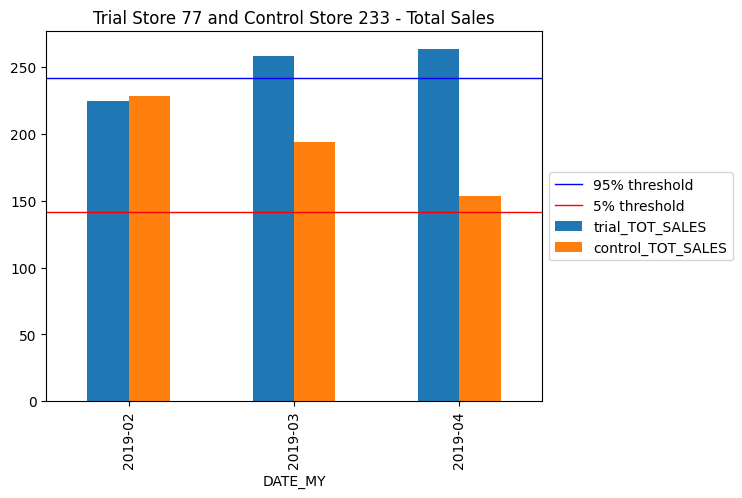

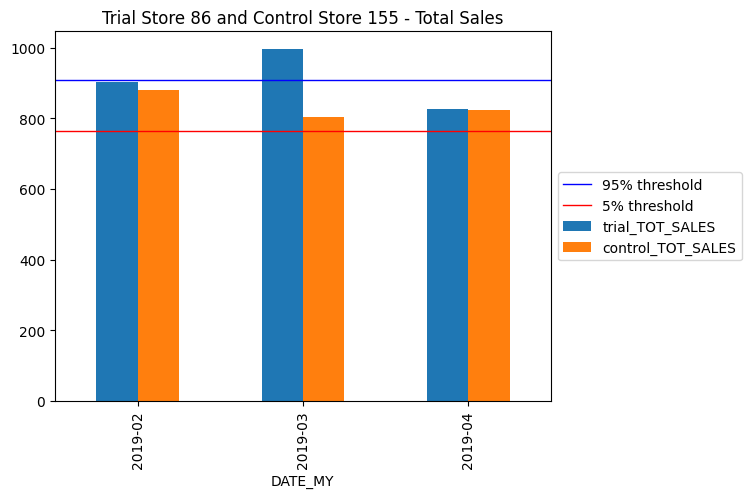

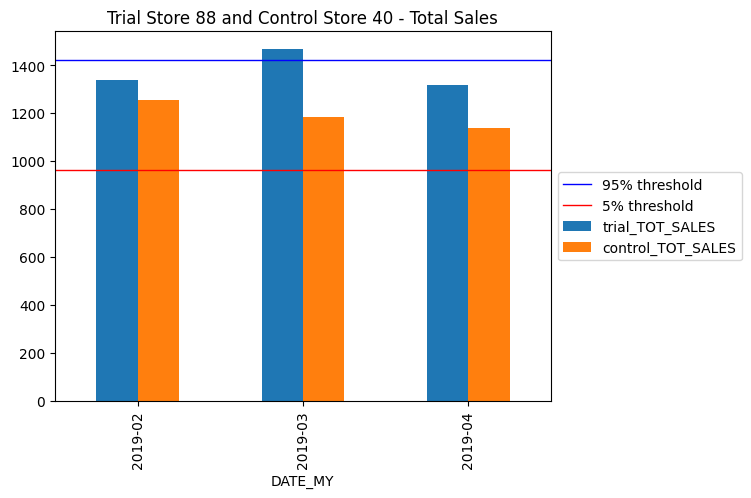

In [233]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"TOT_SALES": "control_TOT_SALES"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "DATE_MY", "TOT_SALES"]].rename(columns={"TOT_SALES": "trial_TOT_SALES"})
    comb = b[['DATE_MY', "trial_TOT_SALES"]].merge(a[['DATE_MY', "control_TOT_SALES"]],on="DATE_MY").set_index("DATE_MY")
    comb.plot.bar()
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["TOT_SALES"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Total Sales")
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")


In [235]:
ncust_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["num_Customers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["num_Customers"].sum()
ncust_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["num_Customers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["num_Customers"].sum()
ncust_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["num_Customers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["num_Customers"].sum()


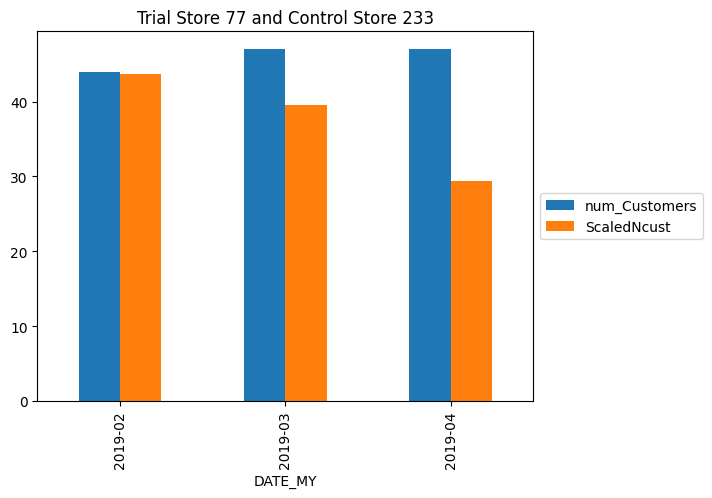

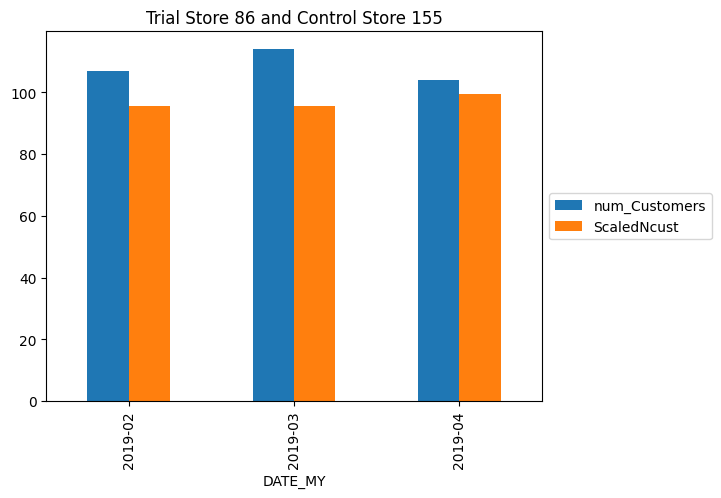

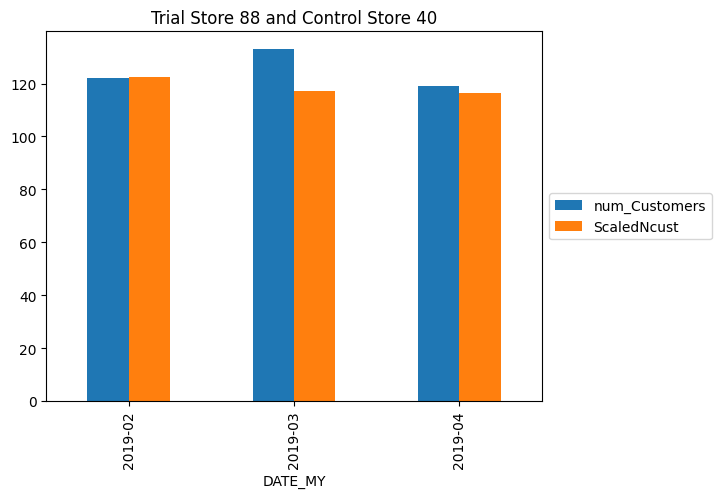

In [238]:
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "DATE_MY", "num_Customers"]]
def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["num_Customers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["num_Customers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["num_Customers"] * ncust_ratio_88
scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)
trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["DATE_MY"].astype('string').str.replace('-','').astype('int64') >= 201902) & (scaled_ncust_control_stores["DATE_MY"].astype('string').str.replace('-','').astype('int64') <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["DATE_MY"].astype('string').str.replace('-','').astype('int64') < 201902]
ncust_percentage_diff = {}
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "DATE_MY", "num_Customers"]]
    ncust_percentage_diff[trial] = b["num_Customers"].sum() / a["ScaledNcust"].sum()
    b[["DATE_MY", "num_Customers"]].merge(a[["DATE_MY", "ScaledNcust"]],on="DATE_MY").set_index("DATE_MY").rename(columns={"ScaledSales":"Scaled_Control_nCust", "TOT_SALES":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [240]:
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "DATE_MY"], ascending=[False, True]).reset_index().drop(["num_Customers", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "DATE_MY", "num_Customers"]].reset_index().drop(["index", "DATE_MY"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "DATE_MY", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))
scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["DATE_MY"].astype('string').str.replace('-','').astype('int64').apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]


,c_STORE_NBR,DATE_MY,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,233,2019-02,43.645646,77,44,0.008086,trial
8,233,2019-03,39.585586,77,47,0.171262,trial
9,233,2019-04,29.435435,77,47,0.459592,trial
19,155,2019-02,95.442455,86,107,0.114181,trial
20,155,2019-03,95.442455,86,114,0.177209,trial
21,155,2019-04,99.503836,86,104,0.044188,trial
31,40,2019-02,122.548180,88,122,-0.004483,trial
32,40,2019-03,117.355460,88,133,0.124979,trial
33,40,2019-04,116.316916,88,119,0.022804,trial


#### Checking significance of Trial minus Control stores by number of Customers Percentage Difference Pre-Trial vs Trial    

In [242]:
#Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"], 
                    trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"], equal_var=False))
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]),len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=0.563571848031469, pvalue=0.5885700785723744)
Store 155
Ttest_indResult(statistic=1.1685639651619202, pvalue=0.2763606797117684)
Store 233
Ttest_indResult(statistic=0.8978908918634146, pvalue=0.4233258546603719)
Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [243]:
#Step 2: Proof control and trial stores are similar statistically
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["num_Customers"],
                    pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == cont]["ScaledNcust"],equal_var=True))
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))


Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.06274144263215267, pvalue=0.9509268215441984)
Trial store: 86 , Control store: 155
Ttest_indResult(statistic=-0.18254648530378673, pvalue=0.8579698540376638)
Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.05164245606169574, pvalue=0.9595986873371789)
Critical t-value for 95% confidence interval:
[-2.36462425  2.36462425]


In [244]:
#Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == cont) & (scaledncust_vs_trial["trial_period"]=="pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()   
    for t_month in scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]["DATE_MY"].unique():
        pdif = scaledncust_vs_trial[(scaledncust_vs_trial["DATE_MY"] == t_month) & (scaledncust_vs_trial["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('')
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
2019-02 : 0.0963096970340144
2019-03 : 3.7526962532857824
2019-04 : 10.213487705542576

Trial store: 86 , Control store: 155
2019-02 : 3.445391474767848
2019-03 : 5.108422334270216
2019-04 : 1.5985701399961638

Trial store: 88 , Control store: 40
2019-02 : -0.08951885918261686
2019-03 : 1.449893087007115
2019-04 : 0.23494938678314942

Critical t-value for 95% confidence interval:
1.9431802803927816


There are 5 months increase in performance that are statistically significant (Above the 95% confidence interval t-score):
March and April trial months for trial store 77
Feb, March and April trial months for trial store 86


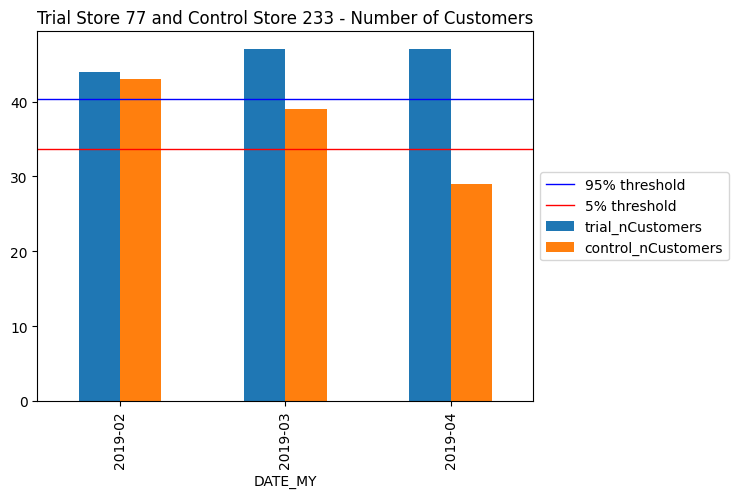

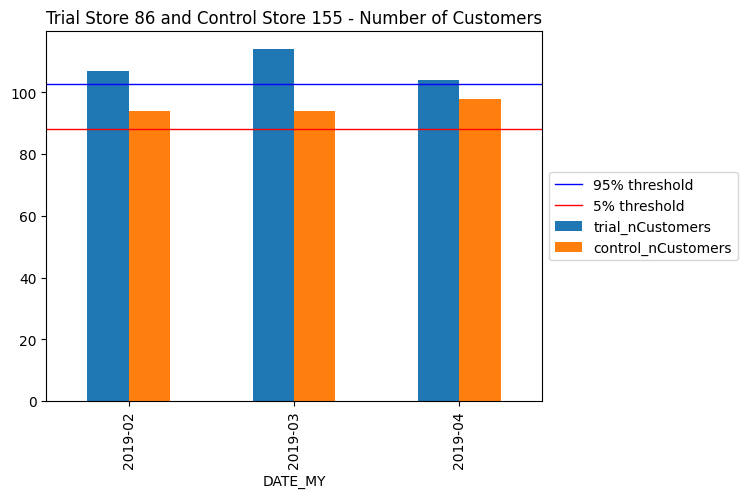

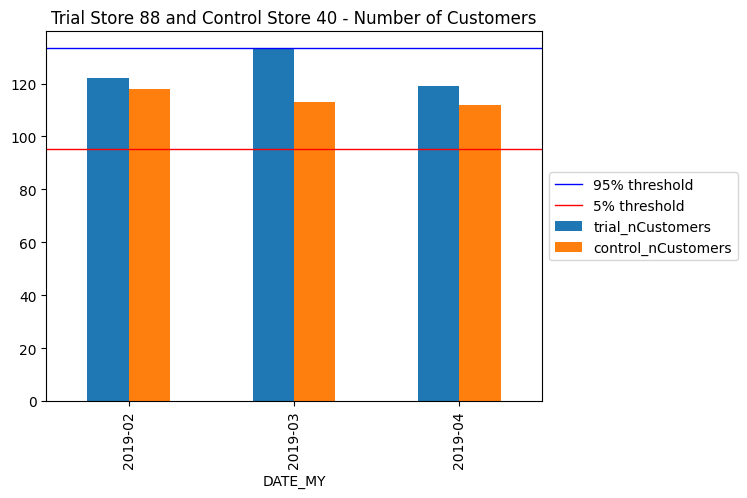

In [245]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"num_Customers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "DATE_MY", "num_Customers"]].rename(columns={"num_Customers": "trial_nCustomers"})
    comb = b[["DATE_MY", "trial_nCustomers"]].merge(a[["DATE_MY", "control_nCustomers"]],on="DATE_MY").set_index("DATE_MY")
    comb.plot.bar()
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["num_Customers"]
    std = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == control) & (scaledncust_vs_trial["trial_period"]=="pre")]["nCust_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial,control), bbox_inches="tight")


Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

#### Conclusion

We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

Overall the trial showed positive significant result.

The results are
- Trial store 77 and 86 sales for Feb, March, and April exceeds 95% threshold of control store.
- Both trial store 77 and 86 showed significant increase in Total Sales and Number of Customers during trial period. 
- But not for trial store 88. 
